In [2]:
import os
import shutil
import sys
import ee
import geemap
import rasterio
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
from datetime import timedelta
import joblib
import numpy as np
import ast
import joblib
import torch
import torchvision

In [25]:
import ee

# Setup
*(just run the cells below)*

In [26]:
ee.Authenticate()

ee.Initialize()

Enter verification code: 4/1AWtgzh6-bRyKSi7JHijouQ2ckQ8Gquviyfm-ELRE5QXcyORA0oDYcAYUbKU

Successfully saved authorization token.


In [3]:
# make sure device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
faster_fp = os.path.abspath('faster300ep.pt')

# load in faster r cnn
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = 2  # 1 class (ship) + background
# get number of input features for the classifier
in_features = faster_rcnn.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
faster_rcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
faster_rcnn.load_state_dict(torch.load(faster_fp))
faster_rcnn.eval()
faster_rcnn.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /tmp/xdg-cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [5]:
def image_splitter(img_fp):
    """
    Takes the image filepath returns m x n array of the subimages
    pads with 0
    """
    #     img = gdal.Open(img_fp)
    #     img_array = img.GetRasterBand(1).ReadAsArray()
    # note have to add in rescaled helper fn

    # define splitting helper function
    # got this from https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7
    def reshape_split(image, kernel_size):
        img_height, img_width = image.shape
        tile_height, tile_width = kernel_size
        
        tiled_array = image.reshape(img_height // tile_height,
                                tile_height,
                                img_width // tile_width,
                                tile_width)
        tiled_array = tiled_array.swapaxes(1,2)
        return tiled_array


    # get image name to return
    # splits full fp by \, then gets the YYYY-MM-DD_#.jpg, then cuts off .jpg 
    img_name = img_fp.split('\\')[-1][:-4]



    with rasterio.open(img_fp) as src:
        img_array = src.read()[0]
#         print(img_array.shape)
        
    # have to clip values to take away gray tint from image
    # and have to do this so that inshore offshore classifier works
    img_array = np.clip(img_array, -20, 0)
    
    img_height, img_width = img_array.shape
    # get next biggest multiple of 800
    # TODO: Make it closest multiple of 800 instead OR PAD WITH BLACK
    new_height = img_height + (800 - img_height % 800)
    new_width = img_width + (800 - img_width % 800)
    
    # calculate number of pixels to pad
    delta_w = new_width - img_width
    delta_h = new_height - img_height
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    
    # pad image with 0
    image_pad = np.pad(img_array, ((top, bottom), (left, right)), mode='constant', constant_values=-20)
    
    # for some reason have to rescale or else when saving image it will be dark
    rescaled = 255*(image_pad-image_pad.min())/(image_pad.max()-image_pad.min())

    # normalize between 0 and 1
    # MAKE A BETTER RESCALING
    rescale_normalized = rescaled / 255
    
    # split image into subimages
        # will return array [m, n, 800, 800] where there are an m x n number of images with size 800x800 
    split = reshape_split(rescale_normalized, kernel_size=(800,800))
    
    return split, img_name

In [18]:
def plot_large_image(model,image_path,threshold,save_path):
    """
    model: pytorch 
    image_path: path tif file
    threshold: confidence threshold for model
    save_path: path to save plot (must be jpg), if none will not save
    """

    # split image and save size for future
    split_image, _ = image_splitter(image_path)
    split_size = split_image.shape[:2]

    # flatten image and format to work with pytroch device
    flattened = np.reshape(split_image, (-1, split_image.shape[2], split_image.shape[3]))
    torch_split_img = np.array(flattened)
    torch_split_img = torch.tensor(torch_split_img,dtype=torch.float32)
    torch_split_img = torch.unsqueeze(torch_split_img, dim=0)
    torch_split_img = torch_split_img.permute(1,0,2,3)
    torch_split_img = torch_split_img.to(device)

    # predict bounding boxes
    pred = model(torch_split_img)
    # reshape to match image split
    pred = np.reshape(pred,split_size)


    # Create a 3x3 plot with a shared axis
#     figsize=(split_size[0], split_size[1])
    fig, axs = plt.subplots(split_size[0], split_size[1], sharex=True, sharey=True, figsize=(split_size[1] * 2, split_size[0] * 2))

    # Loop over the images and annotations and plot them on the corresponding subplot
    for i in range(split_size[0]):
        for j in range(split_size[1]):
            # Plot the image
            axs[i, j].imshow(split_image[i, j], cmap='gray', aspect='auto')
            
            # Remove the axis labels and ticks
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].axis('off')
            # Loop over the annotations and plot them as bounding boxes
            curPred = pred[i, j]
            for k in range(len(curPred["scores"])):
                # checks if above threshold
                if curPred["scores"][k] > threshold:
                    annotation = curPred['boxes'][k]
                    annotation = annotation.cpu().detach().numpy()
                    left, upper, right, lower = annotation
                    width, height = right - left, lower - upper
                    rect = plt.Rectangle((left, upper), width, height, linewidth=1, edgecolor='r', facecolor='none')
                    axs[i, j].add_patch(rect)

    # Remove the space between the images
    plt.subplots_adjust(wspace=0, hspace=0)
    if save_path:
        plt.savefig(save_path,quality=100,dpi=500)
    # Show the plot
    plt.show()

In [11]:
credentials_fp = r'/home/snng/SAR-satelite-image-ship-detection/data_down/gee_download_key/sar-ship-detection-fb527bcf2a6d.json'

service_account = 'snng-download@sar-ship-detection.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, credentials_fp)
ee.Initialize(credentials)

In [30]:
def getImages(place_coords, start_date, end_date, place):
        """
        Given a set of coordinates, start date, and end date, download images from Google Earth Engine into data folder

        place_coords: [(,), (,), (,), (,), (,)]
        start_date: datetime object
        end_date: datetime object
        """
        path = os.path.abspath('')[:-14]
        if not os.path.exists(path + 'data_down/gee_data/{}'.format(place)):
            os.mkdir(path + 'data_down/gee_data/{}'.format(place))
            
        # input given as 'MM/DD/YYYY'
        start_date = datetime.strptime(start_date, '%m/%d/%Y')
        end_date = datetime.strptime(end_date, '%m/%d/%Y')

        # bbox = [(-118.32027994564326,33.64246038322455),(-118.07789408138545,33.64246038322455),(-118.07789408138545,33.78867573774964),(-118.32027994564326,33.78867573774964),(-118.32027994564326,33.64246038322455)]
        bbox = place_coords
        
        # define specificed region
        region = ee.Geometry.Polygon(bbox)

        collection = ee.ImageCollection("COPERNICUS/S1_GRD").filterDate(start_date,end_date).filterBounds(region)
        collection_list = collection.toList(collection.size())
        dates = geemap.image_dates(collection, date_format='YYYY-MM-dd').getInfo()
        
        for i, date in enumerate(dates[:]):
        
            image = ee.Image(collection_list.get(i)).select('VV')

            try:
                geemap.ee_export_image(image, filename = "gee_data/full_img/{}_{}.tif".format(place,date), region = region)
            except Exception as e:
                print(e)

        print('Successfully Downloaded')
        return

In [20]:
os.path.abspath('')[:-14] + 'gee_data'

'/home/snng/SAR-satelite-image-ship-detection/gee_data'

# Port of Los Angeles: Before COVID Lockdown - After COVID Lockdown
## (February 2020 - Mid April 2020)

In [ ]:
# maybe have code to download?

In [11]:
before_img_fp = r'/home/snng/SAR-satelite-image-ship-detection/data_down/gee_data/port_la/2020-02-04.tif'
after_img_fp = r'/home/snng/SAR-satelite-image-ship-detection/data_down/gee_data/port_la/2020-04-11.tif'

**February 2020**

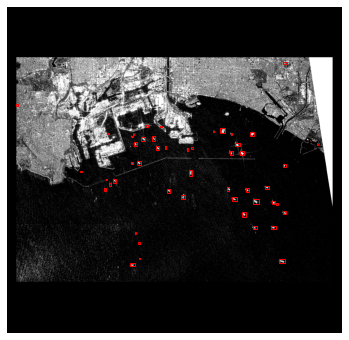

In [21]:
plot_large_image(faster_rcnn, before_img_fp, 0.5, False)

**Mid April 2020**

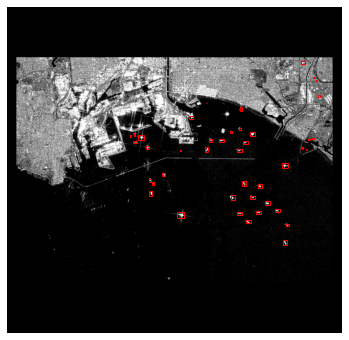

In [22]:
plot_large_image(faster_rcnn, after_img_fp, 0.5, False)

# 2021 Suez Canal Obstruction
- stuck on March 23, 2021
- many ships stuck and backed up on March 28, 2021 
- freed on March 29, 2021
- bbox coords: [(32.53231744717991,29.92297849554313), (32.623641299718976,29.92297849554313), (32.623641299718976,30.171424585887042), (32.53231744717991,30.171424585887042), (32.53231744717991,29.92297849554313)]
    - updated coords [(32.455979434318635,29.900362724445475), (32.61940106517801,29.900362724445475), (32.61940106517801,30.20110234996924), (32.455979434318635,30.20110234996924), (32.455979434318635,29.900362724445475)]
    - updated updated coords [(32.480698672599885,29.884885059249157), (32.618027774162385,29.884885059249157), (32.618027774162385,30.184484522296646), (32.480698672599885,30.184484522296646), (32.480698672599885,29.884885059249157)]

In [44]:
# suez_start = r'/home/snng/SAR-satelite-image-ship-detection/data_down/gee_data/suez_canal/2021-03-24.tif'
# suez_interest = r'/home/snng/SAR-satelite-image-ship-detection/data_down/gee_data/suez_canal/2021-03-27.tif'
# suez_end = r'/home/snng/SAR-satelite-image-ship-detection/data_down/gee_data/suez_canal/2021-03-30.tif'

# updated bounding box
# # suez_start = r'/home/snng/SAR-satelite-image-ship-detection/data_down/gee_data/suez_updated/2021-03-24.tif'
# suez_interest = r'/home/snng/SAR-satelite-image-ship-detection/data_down/gee_data/suez_updated/2021-03-27.tif'
# suez_end = r'/home/snng/SAR-satelite-image-ship-detection/data_down/gee_data/suez_updated/2021-03-30.tif'

# updated updated
suez_start = r'/home/snng/SAR-satelite-image-ship-detection/data_down/gee_data/full_img/2021-03-24.tif'
suez_interest = r'/home/snng/SAR-satelite-image-ship-detection/data_down/gee_data/full_img/2021-03-27.tif'
suez_end = r'/home/snng/SAR-satelite-image-ship-detection/data_down/gee_data/full_img/2021-03-30.tif'


**Start of Ever Given Being Stuck in Suez (March 24, 2021)**

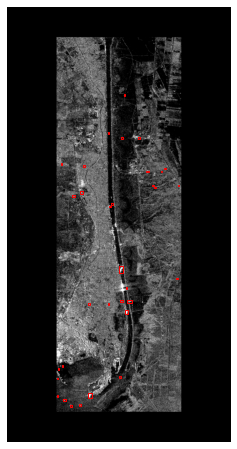

In [38]:
plot_large_image(faster_rcnn, suez_start, 0.6, False)

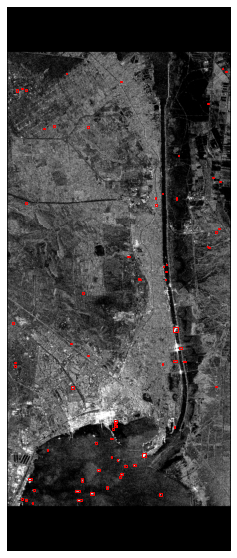

In [33]:
# updated 
plot_large_image(faster_rcnn, suez_start, 0.6, False)

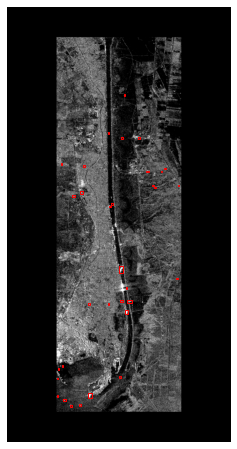

In [41]:
# updated updated
plot_large_image(faster_rcnn, suez_start, 0.6, False)

**Middle of Ever Given Being Stuck (March 27, 2021)**

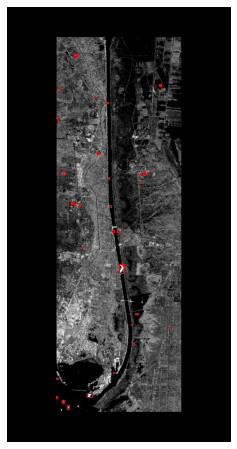

In [39]:
plot_large_image(faster_rcnn, suez_interest, 0.6, False)

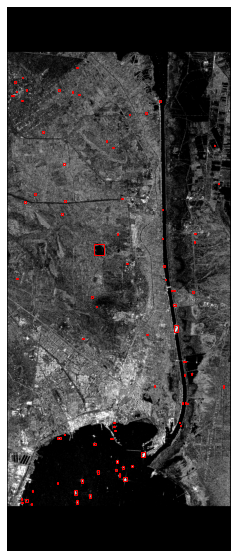

In [49]:
# updated
plot_large_image(faster_rcnn, suez_interest, 0.6, False)

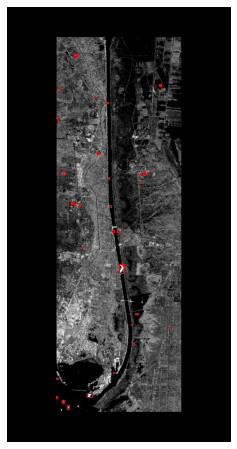

In [42]:
# updated updated
plot_large_image(faster_rcnn, suez_interest, 0.6, False)

**After Ever Given Has Been Freed (March 30, 2021)**

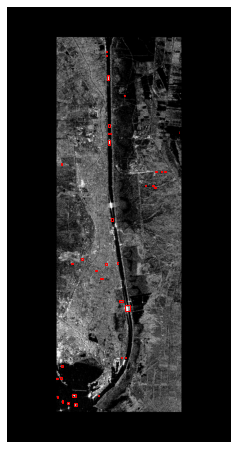

In [24]:
plot_large_image(faster_rcnn, suez_end, 0.6, False)

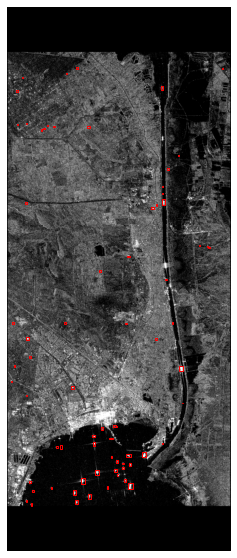

In [45]:
# updated
plot_large_image(faster_rcnn, suez_end, 0.6, False)

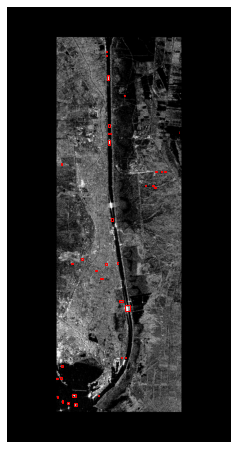

In [43]:
# updated updated
plot_large_image(faster_rcnn, suez_end, 0.6, False)